In [1]:
## load modules

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import glob
import seawater as sw
from dask.diagnostics import ProgressBar
from datetime import datetime

/home/bruno/miniconda3/envs/ocean/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "
/home/bruno/miniconda3/envs/ocean/lib/python3.7/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [3]:
def hov_ext_cdm_dist(x,y,d_file):

    hov_cdm = []

    xi,yi = x.copy(),y.copy() 

    for i in range(len(xi)):
        print("{:03.1f}%".format(100*(i+1)/len(xi)),end="\r")
        hov_cdm.append(d_file.sel(lon=xi[i], lat=yi[i], method='nearest'))

    hov_cdm = xr.concat(hov_cdm,dim='distance')
    hov_cdm = hov_cdm.assign_coords({'distance':np.hstack([0,np.cumsum(sw.dist(yi,xi)[0])])}) #


    with ProgressBar():
        hov_cdm = hov_cdm.compute()
        
    hov_cdm = hov_cdm.interpolate_na('distance').interpolate_na('time')
    
    return hov_cdm

In [4]:
def hov_ext_nemo_dist(x,y,d_file):

    hov_nemo = []

    xi,yi = x.copy(),y.copy() 

    for i in range(len(xi)):
        print("{:03.1f}%".format(100*(i+1)/len(xi)),end="\r")
        hov_nemo.append(d_file.sel(longitude=xi[i], latitude=yi[i], method='nearest'))

    hov_nemo = xr.concat(hov_nemo,dim='distance')
    hov_nemo = hov_nemo.assign_coords({'distance':np.hstack([0,np.cumsum(sw.dist(yi,xi)[0])])}) #


    with ProgressBar():
        hov_nemo = hov_nemo.compute()
        
    hov_nemo = hov_nemo.interpolate_na('distance').interpolate_na('time')
    
    return hov_nemo

In [5]:
from scipy.ndimage.filters import gaussian_filter

# função montar uma matrix para um vetor de batimetria "suave #
def extract_bat(lon,lat,topo,level,flevel):
    CT = plt.contour(gaussian_filter(lon,flevel),
                     gaussian_filter(lat,flevel),gaussian_filter(topo,flevel),
                     [level],colors='black',latlon=True,linewidths=0.7,linestyles='solid')
    # CT = plt.contour(lon,lat,topo,[-100],colors='black',latlon=True,linewidths=0.7,linestyles='solid')
    lli = []
    for i in range(len(CT.allsegs[0])):
        print(CT.allsegs[0][i].shape[0])
        lli.append(CT.allsegs[0][i].shape[0])
        
    lbat = CT.allsegs[0][np.argmax(lli)]
    print('Maior shape é'.format(CT.allsegs[0][np.argmax(lli)].shape))

    return lbat[:,0],lbat[:,1]

In [6]:
# # load chl 

# fsource = sorted(glob.glob('/home/bruno/git/globcolour/gsm-chl/*.nc')
# source   =  [xr.open_dataset(i, chunks={}) for i in fsource]
# time=[datetime.strptime(fi.period_start_day, '%Y%m%d') for fi in source]
# source = xr.concat(source, dim='time')
# source = source.assign_coords(time=time)
# #source

In [7]:
### load nemo 

In [8]:
nemo = xr.open_mfdataset('/home/bruno/git/CMEMS/nemo_data/s_nemo_*')
nemo = nemo.reindex()
nemo.close()


/home/bruno/miniconda3/envs/ocean/lib/python3.7/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [9]:
# print(nemo.attrs)
# print(nemo.var)
# print(nemo.coords)
print(nemo.dims)

Frozen({'depth': 28, 'latitude': 121, 'time': 252, 'longitude': 121})


In [10]:
mask_nemo = nemo.sel(longitude=slice(-50.0, -40.0), latitude=slice(-28.0, -22.0))
mask_nemo.close()

In [11]:
### load cdm 

In [12]:
## Load a  CDM dataset - open time serie of cmems Colored Dissolved organic Matter L3 daily means ###

file = xr.open_mfdataset('/home/bruno/git/CMEMS/cdm_data/oc*') #CDM data ## barra + barra invertida

cdm_file = file.reindex()

cdm_file.close()


In [13]:
# print(cdm_file.attrs)
# print(cdm_file.var)
# print(cdm_file.coords)
print(cdm_file.dims)

Frozen({'time': 8391, 'lat': 481, 'lon': 481})


In [14]:
cdm_data = cdm_file.sel(time=slice('1999','2019'))
#cdm_data=cdm_data.interp({'time': nemo.time})

se_cdm=cdm_data.sel(lat=slice(-22.0, -28),lon=slice(-50.0, -40.0))

cdm_data.close()
se_cdm.close()

###### velocidade ao longo e cruzando a seção 

In [15]:
### @iury: uma dica para criar seções e calcular a velocidade ao longo e cruzando a mesma

##

# n = 40 # numero de pontos

# lons = np.linspace(-46.5,-43.8,n)#lon
# lats = np.linspace(-24,-26,n) #lat
# # dist = np.hstack([0,np.cumsum(sw.dist(lats,lons)[0])])#
# # ang = sw.dist(lats,lons)[1].mean()#

# # points = xr.Dataset(
# #        dict(
# #            latitude=xr.DataArray(lats,dims='dist'),
# #            longitude=xr.DataArray(lons,dims='dist')
# #        )
# # )

# # nemosec = nemo.interp(points).assign_coords(dist=dist)#

# # U = np.exp(-1j*np.deg2rad(ang))*(nemosec.uo+1j*nemosec.vo) #n complexo - rotacional

# # nemosec = nemosec.assign(
# #     cross=U.imag,
# #     along=U.real,
# # )

In [16]:
# ## cross

# (
#     nemosec.cross.sel(dist=slice(0,200))
#     .groupby('time.month').mean()
# ).plot.contourf(col='month',col_wrap=4,ylim=[100,0],levels=10)

# # colobar
# #colocar continente

In [17]:
# ##along

# (
#     nemosec.along.sel(dist=slice(0,200))
#     .groupby('time.month').mean()
# ).plot.contourf(col='month',col_wrap=4,ylim=[100,0],levels=10)

# # colobar
# #colocar continente

In [18]:
# plt.figure()
# # (
# #     nemosec.cross.sel(depth=0,method='nearest')
# #     .groupby('time.season').mean()
# # ).plot.line(hue='season')

# (
#     nemosec.along.sel(depth=0,method='nearest')
#     .groupby('time.season').mean()
# ).plot.line(hue='season',alpha=0.5,add_legend=False)

In [19]:
# nemosec.cross.mean('time').plot(ylim=[200,0],vmin=-0.6,vmax=0.6,cmap='seismic')

In [20]:
# nemosec.along.mean('time').plot(ylim=[200,0],vmin=-0.3,vmax=0.3,cmap='seismic')

PLOTS VELOCIDADE

In [21]:
# i = 5
# sel = lambda A: A.sel(longitude=slice(None,None,i),latitude=slice(None,None,i)).sel(depth=0,method='nearest').mean('time')


# land = cfeature.NaturalEarthFeature(
#     'physical','land','10m',edgecolor='face',facecolor='0.5'
# )

# proj = ccrs.Mercator()

# kw = dict(transform=ccrs.PlateCarree())

# fig,ax = plt.subplots(figsize=(8,8))

# ax = fig.add_subplot(1,1,1,projection=proj)

# ax.quiver(sel(nemo).longitude,sel(nemo).latitude,sel(nemo.uo),sel(nemo.vo))

# #ax.plot(lons,lats,'red')
# ax.coastlines()
# #ax.add_feature(land)
# gl = ax.gridlines(draw_labels=True,linestyle='--')
# gl.top_labels = False
# gl.right_labels = False
# gl.bottom_labels = False
# gl.left_labels = False
# #ax.set_extent([
#    # -50, -40,
#     #-28, -22
# #],crs=ccrs.PlateCarree())
# #ax.axis('scaled')

In [22]:
#lat, lon = nemo.latitude, nemo.longitude

In [ ]:
# ## definiçoes cartopy

# land = cfeature.NaturalEarthFeature(
#     'physical','land','10m',edgecolor='face',facecolor='0.5'
# )

# proj = ccrs.Mercator()

# kw = dict(transform=ccrs.PlateCarree())

# # plot velocidade 

# sel = lambda A: A.sel(depth=0,method='nearest').mean('time') # função sel agrupa os dados 
#                                                                 #de acordo com a batimetria

# fig = plt.figure(figsize=(12,9))
# ax = fig.add_subplot(1,1,1,projection=proj)
# ax1 = sel(np.sqrt(nemo.uo**2+nemo.vo**2)).plot.contourf(ax=ax,robust=True, cmap='seismic', levels=18,**kw)
# #ax.contour(lon,lat,mask_bat,levels=[-200],colors=['black'])
# #ax.contour(lon,lat,mask_bat,levels=[-800],colors=['black'])
# ax.coastlines()
# ax.add_feature(land)
# g = ax.gridlines(draw_labels=True,linestyle='--')
# g.top_labels = False
# g.right_labels = False
# ax.set_extent([
#     -50, -40,
#     -28, -22
# ],crs=ccrs.PlateCarree())

# # COLOBAR

# cbar = fig.colorbar(ax1, orientation= "horizontal", aspect=90, fraction=0.06, pad=0.06)
# # cbar.set_label(r'sea surface temp. [C°]')

# # #plt.show()

# # plt.contour(lon,lat,mask_bat,levels=[-200],colors=['black'])
# # plt.contour(lon,lat,mask_bat,levels=[-800],colors=['black'])

# plt.show()
# # 

###### Batimetria

In [23]:
bat = xr.open_dataset('/home/bruno/git/CMEMS/gebco/gebco_2020_n-20.0_s-40.0_w-60.0_e-40.0.nc')


In [24]:
mask_bat = bat.interp({'lon':mask_nemo.longitude, 'lat':mask_nemo.latitude}).elevation

bat.close()
mask_bat.close()

In [ ]:
# hovmollers

In [ ]:
#velo=sel(np.sqrt(nemo.uo**2+nemo.vo**2))

In [ ]:
#mask_velo= velo.sel(longitude=slice(-50.0, -41.0), latitude=slice(-28.0, -22.0))

In [ ]:
# fig = plt.figure(figsize=(12,9))
# mask_velo.plot.contourf(ax=ax,robust=True, cmap='seismic', levels=18,**kw)
# plt.show()

In [ ]:
# #----------- SELEÇÃO SEÇÕES DE ACORDO COM A BATIMETRIA SUAVE ---------------- #

# xbat,ybat,zbat = mask_bat.lat.values,mask_bat.lon.values,mask_bat.values

# x, y =  extract_bat(ybat, xbat, zbat, level = -80, flevel = 0.5
#                    ) # SELECIONANDO VETORES
# # x_1, y_1 = extract_bat(ybat, xbat, zbat, level = -100, flevel = 10)
# # x_2, y_2 = extract_bat(ybat, xbat, zbat, level = -150, flevel = 10)
# #x_3, y_3 = extract_bat(ybat, xbat, zbat, level = -200, flevel = 10)


# x,y = x[::2],y[::2]
# # x_1,y_1 = x_1[::10],y_1[::10] 
# # x_2,y_2 = x_2[::10],y_2[::10]
# #x_3,y_3 = x_3[::10],y_3[::10]

In [25]:
nemo

<xarray.Dataset>
Dimensions:    (depth: 28, latitude: 121, time: 252, longitude: 121)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 ... 186.1 222.5 266.0
  * latitude   (latitude) float32 -30.0 -29.92 -29.83 ... -20.17 -20.08 -20.0
  * time       (time) datetime64[ns] 1999-01-16T12:00:00 ... 2019-12-16T12:00:00
  * longitude  (longitude) float32 -50.0 -49.92 -49.83 ... -40.17 -40.08 -40.0
Data variables:
    vo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(12, 28, 121, 121), meta=np.ndarray>
    uo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(12, 28, 121, 121), meta=np.ndarray>
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [37]:
hov_nemo  = hov_ext_nemo_dist(x,y,mask_nemo)

uo, vo = hov_nemo.uo.sel(depth = 0, method = 'nearest').interpolate_na(
    'time'), hov_nemo.vo.sel(depth = 0, method = 'nearest').interpolate_na('time')

hov_nemo.close()
uo.close()
vo.close()

[########################################] | 100% Completed |  1.6s


In [38]:
hov_nemo

<xarray.Dataset>
Dimensions:    (depth: 28, distance: 78, time: 252)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 ... 186.1 222.5 266.0
  * distance   (distance) float64 0.0 4.366 13.86 22.04 ... 955.7 966.9 973.3
    latitude   (distance) float32 -22.33 -22.33 -22.42 ... -27.5 -27.58 -27.67
    longitude  (distance) float32 -41.0 -41.08 -41.17 ... -48.0 -48.0 -48.0
  * time       (time) datetime64[ns] 1999-01-16T12:00:00 ... 2019-12-16T12:00:00
Data variables:
    vo         (distance, time, depth) float32 -0.3101 -0.3009 ... nan nan
    uo         (distance, time, depth) float32 -0.1263 -0.1221 ... nan nan
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [29]:
#(hov_nemo.latitude)

In [30]:
# print('matriz para o calculo de dados de velocidade')
# #nemo.uo

In [31]:
# print('check')
# uo, vo

In [32]:
#velocidade = xr.ufuncs.sqrt(uo**2+vo**2)

In [39]:
velocidade = np.sqrt(uo**2+vo**2)


In [64]:
#velocidade

In [ ]:
#velocidade = velocidade.T

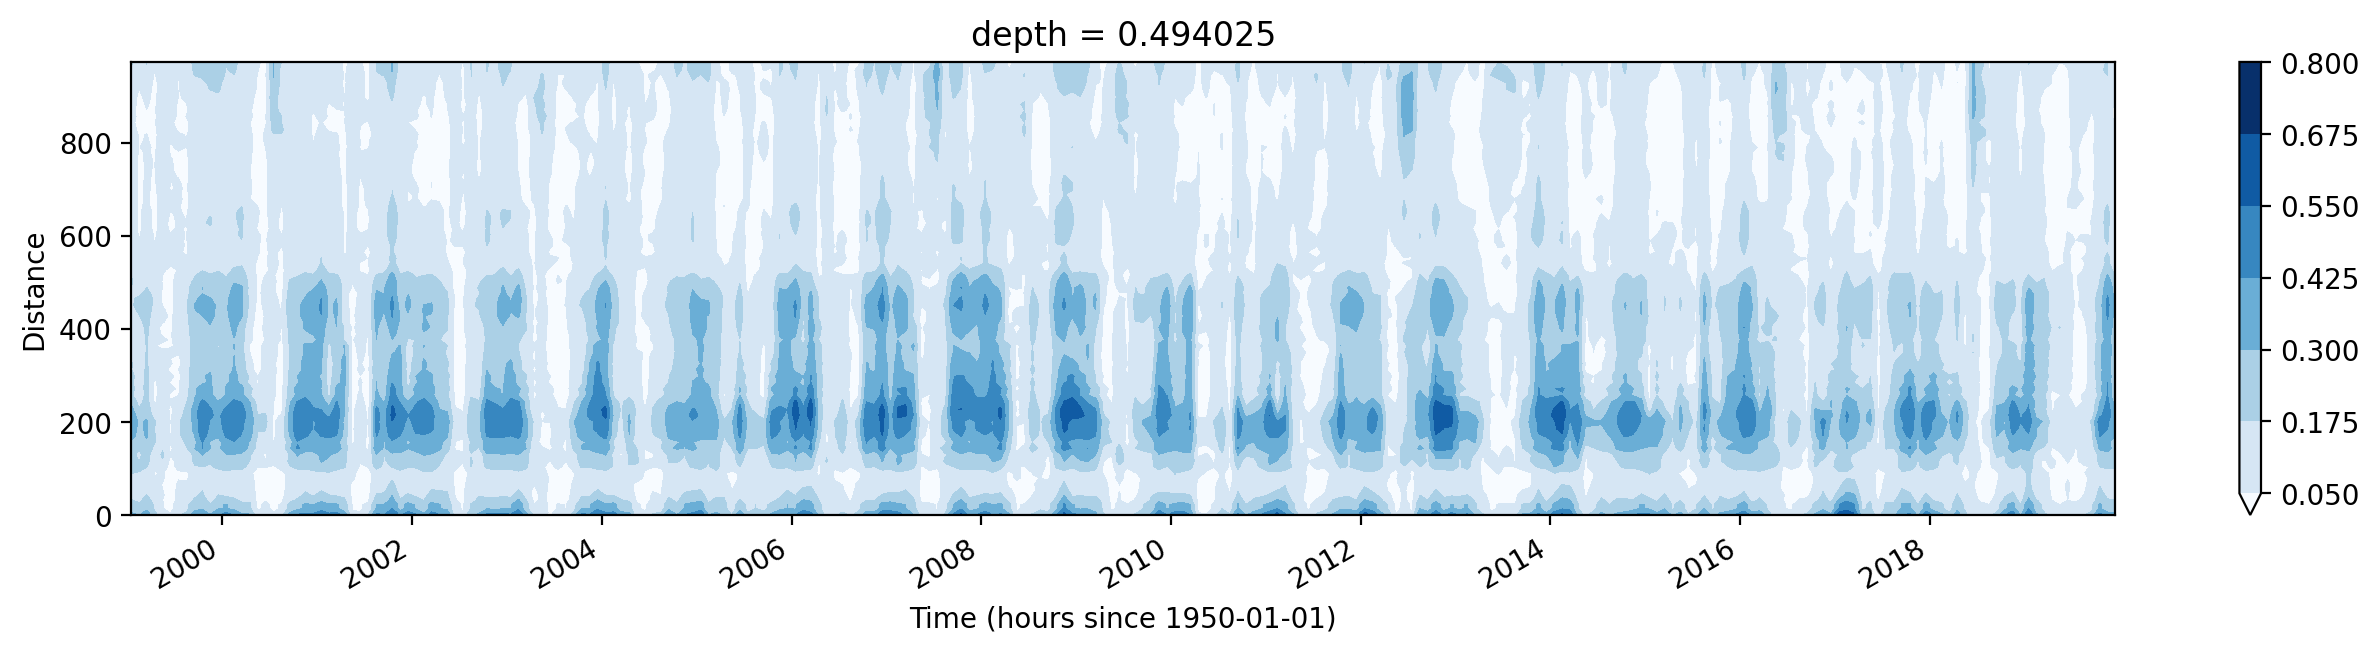

In [21]:
# plt.figure(figsize=(12 ,3), dpi =200)
# velocidade.plot.contourf(x='latitude', vmin=0,vmax=0.9, cmap='Blues', robust=True)
# #plt.xlabel('month')
# plt.ylabel('Time')
# #plt.title('Diagrama de Hovmoller seçao 80 metros - serie mensal ' r'$log_{10}$[CDM] (m$^{-1}$)')
# plt.tight_layout()

plt.figure(figsize=(16 ,3), dpi =200)
velocidade.plot.contourf(y='distance', vmin=0.05,vmax=0.8, cmap='Blues', robust=True)
#plt.xlabel('month')
plt.ylabel('Distance')
#plt.title('Diagrama de Hovmoller seçao 80 metros - serie mensal ' r'$log_{10}$[CDM] (m$^{-1}$)')
velocidade.close()

In [ ]:
# cdom

In [35]:
mask_cdm_bat = bat.interp({'lon':se_cdm.lon, 'lat':se_cdm.lat}).elevation

311
Maior shape é


/home/bruno/miniconda3/envs/ocean/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The following kwargs were not used by contour: 'latlon'
  import sys


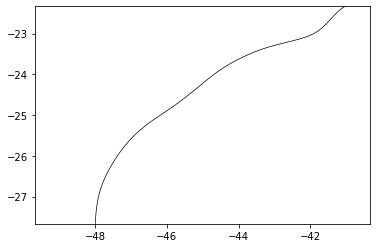

In [36]:
#----------- SELEÇÃO SEÇÕES DE ACORDO COM A BATIMETRIA SUAVE ---------------- #

xbat,ybat,zbat = mask_cdm_bat.lat.values,mask_cdm_bat.lon.values,mask_cdm_bat.values

x, y =  extract_bat(ybat, xbat, zbat, level = -80, flevel = 10) # SELECIONANDO VETORES
# x_1, y_1 = extract_bat(ybat, xbat, zbat, level = -200, flevel = 10)
# x_2, y_2 = extract_bat(ybat, xbat, zbat, level = -600, flevel = 10)
# x_3, y_3 = extract_bat(ybat, xbat, zbat, level = -2000, flevel = 10)


x,y = x[::4],y[::4]
# x_1,y_1 = x_1[::10],y_1[::10] 
# x_2,y_2 = x_2[::10],y_2[::10]
# x_3,y_3 = x_3[::10],y_3[::10]

In [ ]:
#select a hovmoller

In [40]:
hov_cdm  = hov_ext_cdm_dist(x,y,se_cdm)

[########################################] | 100% Completed |  1min 13.0s


In [29]:
cdm = hov_cdm.CDM.resample({'time':'30D'}).mean()

In [41]:
#cdm

Interpolações necessárias

In [ ]:
#velo

In [ ]:
#hov_cdm.CDM

In [42]:
cdm = hov_cdm.CDM.interp({'distance':velocidade.distance, 'time':velocidade.time})


In [43]:
doc=cdm*0.5864

In [47]:
#cdm, velo = hov_cdm.CDM, velocidade

In [ ]:
#cdm.interpolate_na('time')

In [ ]:
#velo.distance

In [ ]:
#velo.latitude

In [44]:
fluxo = doc * velocidade

In [62]:
#fluxo

Text(0, 0.5, '[S]')

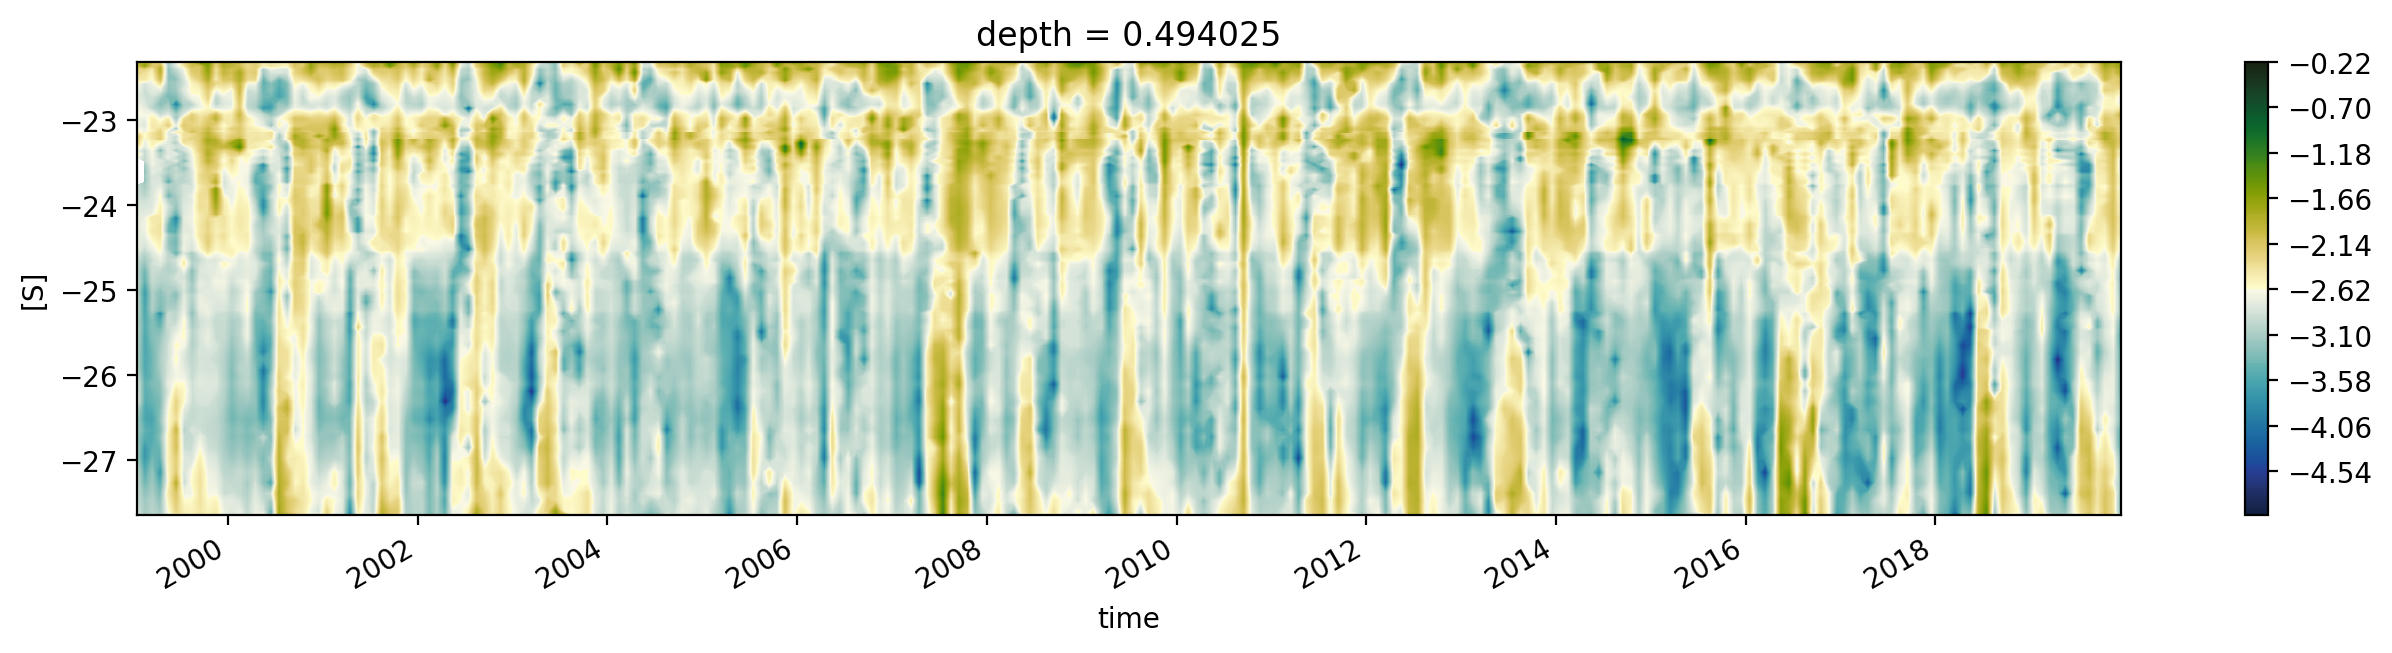

In [59]:
import cmocean as cmo

plt.figure(figsize=(16 ,3), dpi =200)

np.log10(fluxo).plot.contourf(y='lat', vmin= -5.0, vmax=-0.2, 
                              levels=np.arange(-5.0, -0.2, 0.02), cmap= cmo.cm.delta,robuste = True) #  80 igual ao syl
plt.xlabel('time')
plt.ylabel('[S]')


Text(0, 0.5, '[S]')

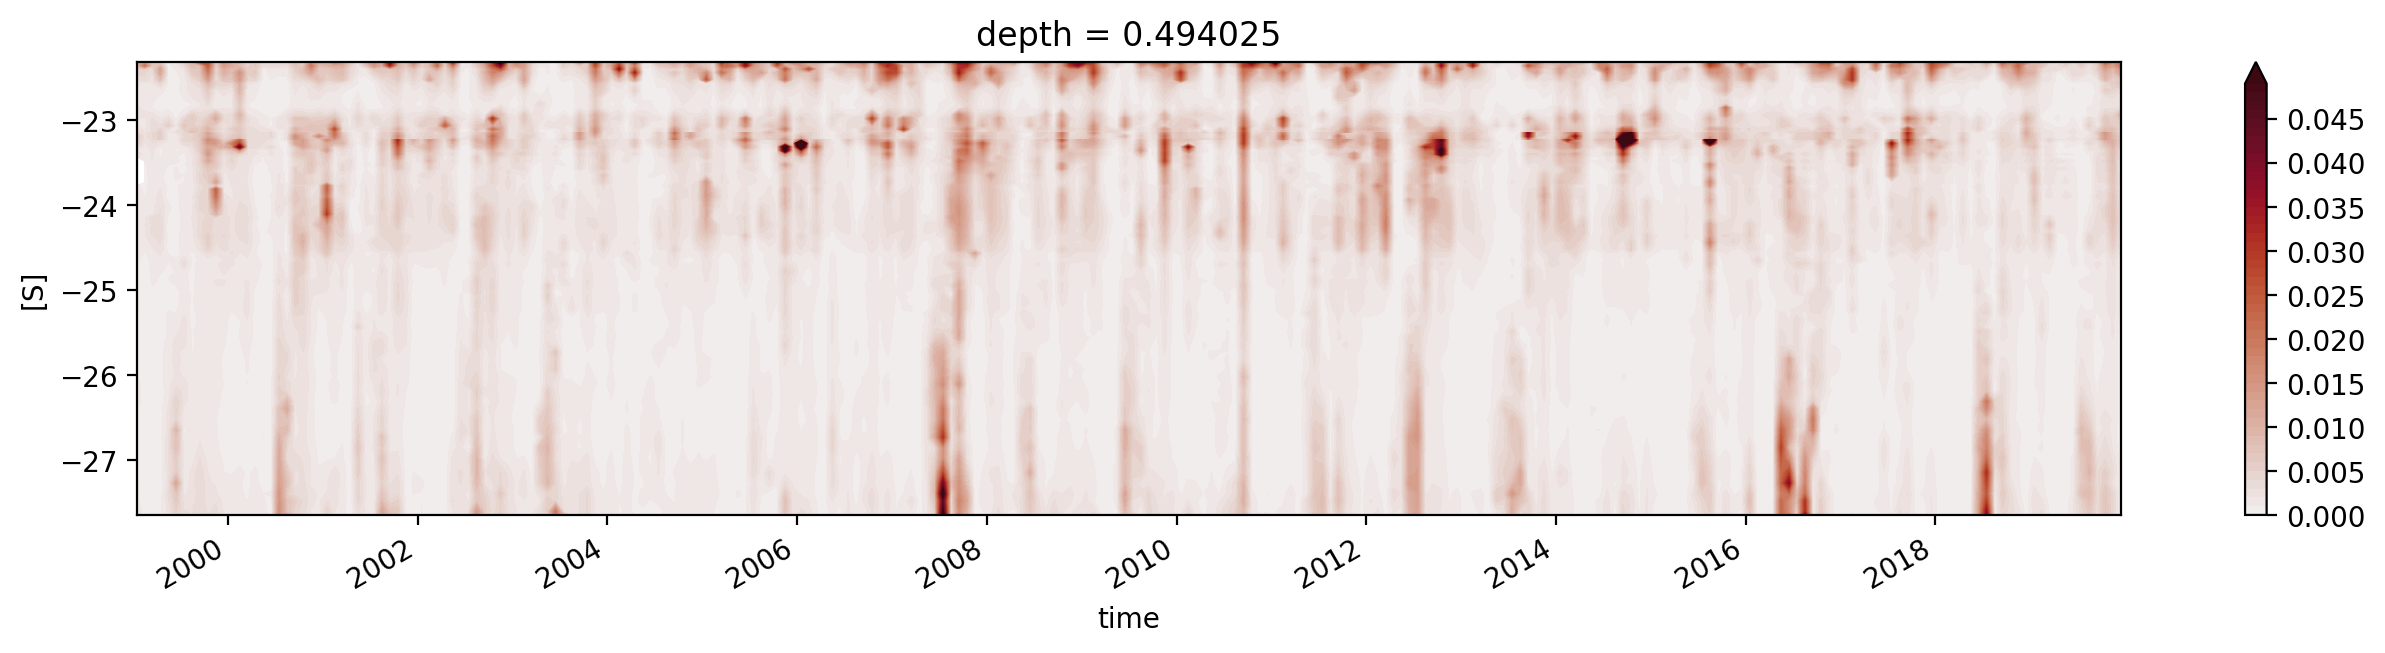

In [53]:


plt.figure(figsize=(16 ,3), dpi =200)

fluxo.plot.contourf(y='lat', vmin= 0.0, vmax=0.05, 
                              levels=np.arange(0.0, 0.05, 0.001), cmap= cmo.cm.amp,robuste = True) #  80 igual ao syl
plt.xlabel('time')
plt.ylabel('[S]')

In [48]:
fluxo

<xarray.DataArray (distance: 78, time: 252)>
array([[0.01151265, 0.0109979 , 0.00711535, ..., 0.02323813, 0.01490993,
        0.01992638],
       [0.00835226, 0.02005571, 0.00625853, ..., 0.01616732, 0.01222779,
        0.02109599],
       [0.0048069 , 0.00514768, 0.00337303, ..., 0.01283318, 0.00832039,
        0.01484643],
       ...,
       [0.00110276, 0.0006875 , 0.00088252, ..., 0.00705502, 0.0039796 ,
        0.00035551],
       [0.00136947, 0.00070543, 0.0009448 , ..., 0.00709388, 0.0040894 ,
        0.00037109],
       [0.00141354, 0.0006865 , 0.00099125, ..., 0.00700687, 0.00414121,
        0.00053945]])
Coordinates:
    lon        (distance) float64 -41.02 -41.06 -41.15 ... -47.98 -47.98 -47.98
    lat        (distance) float64 -22.31 -22.35 -22.4 ... -27.48 -27.6 -27.65
  * distance   (distance) float64 0.0 4.366 13.86 22.04 ... 955.7 966.9 973.3
  * time       (time) datetime64[ns] 1999-01-16T12:00:00 ... 2019-12-16T12:00:00
    depth      float32 0.494
    latitude   (distance) float32 -22.33 -22.33 -22.42 ... -27.5 -27.58 -27.67
    longitude  (distance) float32 -41.0 -41.08 -41.17 ... -48.0 -48.0 -48.0